In [1]:
%%javascript
    MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });

<IPython.core.display.Javascript object>

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('div.prompt').hide();
 } else {
 $('div.input').show();
$('div.prompt').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Code Toggle"></form>''')

In [3]:
from IPython.display import HTML

HTML('''
<a href="https://github.com/usnistgov/pfhub/raw/master/benchmarks/benchmark7.ipynb"
   download>
<button type="submit">Download Notebook</button>
</a>
''')

# Benchmark Problem 7: MMS Allen-Cahn

In [4]:
from IPython.display import HTML

HTML('''{% include jupyter_benchmark_table.html num="[7]" revision=0 %}''')

<h4>Table of Contents<span class="tocSkip"></span></h4>

<div class="toc"><ul class="toc-item"><li><span><a href="#Benchmark-Problem-7:-MMS-Allen-Cahn" data-toc-modified-id="Benchmark-Problem-7:-MMS-Allen-Cahn-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Benchmark Problem 7: MMS Allen-Cahn</a></span></li><li><span><a href="#Overview" data-toc-modified-id="Overview-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Governing-equation-and-manufactured-solution" data-toc-modified-id="Governing-equation-and-manufactured-solution-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Governing equation and manufactured solution</a></span></li><li><span><a href="#Domain-geometry,-boundary-conditions,-initial-conditions,-and-stopping-condition" data-toc-modified-id="Domain-geometry,-boundary-conditions,-initial-conditions,-and-stopping-condition-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Domain geometry, boundary conditions, initial conditions, and stopping condition</a></span></li><li><span><a href="#Parameter-values" data-toc-modified-id="Parameter-values-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Parameter values</a></span></li><li><span><a href="#Benchmark-simulation-instructions" data-toc-modified-id="Benchmark-simulation-instructions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Benchmark simulation instructions</a></span><ul class="toc-item"><li><span><a href="#Part-(a)" data-toc-modified-id="Part-(a)-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Part (a)</a></span></li><li><span><a href="#Part-(b)" data-toc-modified-id="Part-(b)-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Part (b)</a></span></li><li><span><a href="#Part-(c)" data-toc-modified-id="Part-(c)-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Part (c)</a></span></li></ul></li><li><span><a href="#Submission-Guidelines" data-toc-modified-id="Submission-Guidelines-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Submission Guidelines</a></span><ul class="toc-item"><li><span><a href="#Part-(a)-Guidelines" data-toc-modified-id="Part-(a)-Guidelines-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Part (a) Guidelines</a></span></li><li><span><a href="#Parts-(b)-and-(c)-Guidelines" data-toc-modified-id="Parts-(b)-and-(c)-Guidelines-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Parts (b) and (c) Guidelines</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Feedback" data-toc-modified-id="Feedback-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Feedback</a></span></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Appendix</a></span><ul class="toc-item"><li><span><a href="#Computer-algebra-systems" data-toc-modified-id="Computer-algebra-systems-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Computer algebra systems</a></span></li><li><span><a href="#Source-term" data-toc-modified-id="Source-term-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>Source term</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-10.3"><span class="toc-item-num">10.3&nbsp;&nbsp;</span>Code</a></span><ul class="toc-item"><li><span><a href="#Python" data-toc-modified-id="Python-10.3.1"><span class="toc-item-num">10.3.1&nbsp;&nbsp;</span>Python</a></span></li><li><span><a href="#C" data-toc-modified-id="C-10.3.2"><span class="toc-item-num">10.3.2&nbsp;&nbsp;</span>C</a></span></li><li><span><a href="#Fortran" data-toc-modified-id="Fortran-10.3.3"><span class="toc-item-num">10.3.3&nbsp;&nbsp;</span>Fortran</a></span></li><li><span><a href="#Julia" data-toc-modified-id="Julia-10.3.4"><span class="toc-item-num">10.3.4&nbsp;&nbsp;</span>Julia</a></span></li><li><span><a href="#Mathematica" data-toc-modified-id="Mathematica-10.3.5"><span class="toc-item-num">10.3.5&nbsp;&nbsp;</span>Mathematica</a></span></li><li><span><a href="#Matlab" data-toc-modified-id="Matlab-10.3.6"><span class="toc-item-num">10.3.6&nbsp;&nbsp;</span>Matlab</a></span></li></ul></li></ul></li></ul></div>

See the journal publication entitled ["Benchmark problems for numerical implementations of phase field models"][benchmark_paper] for more details about the benchmark problems. Furthermore, read [the extended essay][benchmarks] for a discussion about the need for benchmark problems.

[benchmarks]: ../
[benchmark_paper]: http://dx.doi.org/10.1016/j.commatsci.2016.09.022

# Overview

The Method of Manufactured Solutions (MMS) is a powerful technique for verifying the accuracy of a simulation code. In the MMS, one picks a desired solution to the problem at the outset, the "manufactured solution", and then determines the governing equation that will result in that solution. With the exact analytical form of the solution in hand, when the governing equation is solved using a particular simulation code, the deviation from the expected solution can be determined exactly. This deviation can be converted into an error metric to rigously quantify the error for a calculation. This error can be used to determine the order of accuracy of the simulation results to verify simulation codes. It can also be used to compare the computational efficiency of different codes or different approaches for a particular code at a certain level of error. Furthermore, the spatial/temporal distribution can give insight into the conditions resulting in the largest error (high gradients, changes in mesh resolution, etc.).

After choosing a manufactured solution, the governing equation must be modified to force the solution to equal the manufactured solution. This is accomplished by taking the nominal equation that is to be solved (e.g.  Allen-Cahn equation, Cahn-Hilliard equation, Fick's second law, Laplace equation) and adding a source term. This source term is determined by plugging the manufactured solution into the nominal governing equation and setting the source term equal to the residual. Thus, the manufactured solution satisfies the MMS governing equation (the nominal governing equation plus the source term). A more detailed discussion of MMS can be found in [the report by Salari and Knupp][mms_report].

In this benchmark problem, the objective is to use the MMS to rigorously verify phase field simulation codes and then provide a basis of comparison for the computational performance between codes and for various settings for a single code, as discussed above. To this end, the benchmark problem was chosen as a balance between two factors: simplicity, to minimize the development effort required to solve the benchmark, and transferability to a real phase field system of physical interest. 

[mms_report]: http://prod.sandia.gov/techlib/access-control.cgi/2000/001444.pdf

# Governing equation and manufactured solution
For this benchmark problem, we use a simple Allen-Cahn equation as the governing equation

$$\begin{equation}
\frac{\partial \eta}{\partial t} = - \left[ 4 \eta \left(\eta - 1 \right) \left(\eta-\frac{1}{2} \right) - \kappa \nabla^2 \eta \right] + S(x,y,t) 
\end{equation}$$

where $S(x,y,t)$ is the MMS source term and $\kappa$ is a constant parameter (the gradient energy coefficient). 

The manufactured solution, $\eta_{sol}$ is a hyperbolic tangent function, shifted to vary between 0 and 1, with the $x$ position of the middle of the interface ($\eta_{sol}=0.5$) given by the function $\alpha(x,t)$:

$$\begin{equation}
\eta_{sol}(x,y,t) = \frac{1}{2}\left[ 1 - \tanh\left( \frac{y-\alpha(x,t)}{\sqrt{2 \kappa}} \right) \right] 
\end{equation}$$

$$\begin{equation}
\alpha(x,t) = \frac{1}{4} + A_1 t \sin\left(B_1 x \right) + A_2 \sin \left(B_2  x + C_2 t \right)
\end{equation}$$

where $A_1$, $B_1$, $A_2$, $B_2$, and $C_2$ are constant parameters. 

This manufactured solution is an equilbrium solution of the governing equation, when $S(x,y,t)=0$ and $\alpha(x,t)$ is constant. The closeness of this manufactured solution to a solution of the nominal governing equation increases the likihood that the behavior of simulation codes when solving this benchmark problem is representive of the solution of the regular Allen-Cahn equation (i.e. without the source term). The form of $\alpha(x,t)$ was chosen to yield complex behavior while still retaining a (somewhat) simple functional form. The two spatial sinusoidal terms introduce two controllable length scales to the interfacial shape. Summing them gives a  "beat" pattern with a period longer than the period of either individual term, permitting a domain size that is larger than the wavelength of the sinusoids without a repeating pattern. The temporal sinusoidal term introduces a controllable time scale to the interfacial shape in addition to the phase transformation time scale, while the linear temporal dependence of the other term ensures that the sinusoidal term can go through multiple periods without $\eta_{sol}$ repeating itself.

Inserting the manufactured solution into the governing equation and solving for $S(x,y,t)$ yields:

$$\begin{equation}
S(x,y,t) = \frac{\text{sech}^2 \left[ \frac{y-\alpha(x,t)}{\sqrt{2 \kappa}} \right]}{4 \sqrt{\kappa}} \left[-2\sqrt{\kappa} \tanh \left[\frac{y-\alpha(x,t)}{\sqrt{2 \kappa}} \right] \left(\frac{\partial \alpha(x,t)}{\partial x} \right)^2+\sqrt{2} \left[ \frac{\partial \alpha(x,t)}{\partial t}-\kappa \frac{\partial^2 \alpha(x,t)}{\partial x^2} \right] \right]
\end{equation}$$

where $\alpha(x,t)$ is given above and where:

$$\begin{equation}
\frac{\partial \alpha(x,t)}{\partial x} = A_1 B_1 t \cos\left(B_1 x\right) + A_2 B_2 \cos \left(B_2  x + C_2 t \right)
\end{equation}$$

$$\begin{equation}
\frac{\partial^2 \alpha(x,t)}{\partial x^2} = -A_1 B_1^2 t \sin\left(B_1 x\right) - A_2 B_2^2 \sin \left(B_2  x + C_2 t \right)
\end{equation}$$

$$\begin{equation}
\frac{\partial \alpha(x,t)}{\partial t} = A_1 \sin\left(B_1 x\right) + A_2 C_2 \cos \left(B_2  x + C_2 t \right)
\end{equation}$$

** *N.B.*: Don't transcribe these equations. Please download the appropriate files from the [Appendix](#Appendix) **.

# Domain geometry, boundary conditions, initial conditions, and stopping condition
The domain geometry is a rectangle that spans [0, 1] in $x$ and [0, 0.5] in $y$. This elongated domain was chosen to allow multiple peaks and valleys in $\eta_{sol}$ without stretching the interface too much in the $y$ direction (which causes the thickness of the interface to change) or having large regions where $\eta_{sol}$  never deviates from 0 or 1. Periodic boundary conditions are applied along the $x = 0$ and the $x = 1$ boundaries to accomodate the periodicity of $\alpha(x,t)$. Dirichlet boundary conditions of $\eta$ = 1 and $\eta$ = 0 are applied along the $y = 0$ and the $y = 0.5$ boundaries, respectively. These boundary conditions are chosen to be consistent with $\eta_{sol}(x,y,t)$. The initial condition is the manufactured solution at $t = 0$:

$$
\begin{equation}
\eta_{sol}(x,y,0) = \frac{1}{2}\left[ 1 - \tanh\left( \frac{y-\left(\frac{1}{4}+A_2 \sin(B_2 x) \right)}{\sqrt{2 \kappa}} \right) \right] 
\end{equation}
$$

The stopping condition for all calculations is when t = 8 time units, which was chosen to let $\alpha(x,t)$ evolve substantially, while still being slower than the characteristic time for the phase evolution (determined by the CFL condition for a uniform mesh with a reasonable level of resolution of $\eta_{sol}$).

# Parameter values
The nominal parameter values for the governing equation and manufactured solution are given below. The value of $\kappa$ will change in Part (b) in the following section and the values of $\kappa$ and $C_2$ will change in Part (c).

| Parameter | Value |
|-----------|-------|
| $\kappa$  | 0.0004|
| $A_1$     | 0.0075|
| $B_1$     | $8.0 \pi$  |
| $A_2$     | 0.03   |
| $B_2$     | $22.0 \pi$  |
| $C_2$     | $0.0625 \pi$|

# Benchmark simulation instructions
This section describes three sets of tests to conduct using the MMS problem specified above. The primary purpose of the first test is provide a computationally inexpensive problem to verify a simulation code. The second and third tests are more computationally demanding and are primarily designed to serve as a basis for performance comparisons.

## Part (a)
The objective of this test is to verify the accuracy of your simulation code in both time and space. Here, we make use of convergence tests, where either the mesh size (or grid point spacing) or the time step size is systematically changed to determine the response of the error to these quantities. Once a convergence test is completed the order of accuracy can be calculated from the result. The order of accuracy can be compared to the theoretical order of accuracy for the numerical method employed in the simulation. If the two match (to a reasonable degree), then one can be confident that the simulation code is working as expected. The remainder of this subsection will give instructions for convergence tests for this MMS problem.

Implement the MMS problem specified above using the simulation code of your choice. Perform a spatial convergence test by running the simulation for a variety of mesh sizes. For each simulation, determine the discrete $L_2$ norm of the error at $t=8$:

$$\begin{equation}
    L_2 = \sqrt{\sum\limits_{x,y}\left(\eta^{t=8}_{x,y} - \eta_{sol}(x,y,8)\right)^2 \Delta x \Delta y}
\end{equation}$$

For all of these simulations, verify that the time step is small enough that any temporal error is much smaller that the total error. This can be accomplished by decreasing the time step until it has minimal effect on the error. Ensure that at least three simulation results have $L_2$ errors in the range $[5\times10^{-3}, 1\times10^{-4}]$, attempting to cover as much of that range as possible/practical. This maximum and minimum errors in the range roughly represent a poorly resolved simulation and a very well-resolved simulation.

Save the effective element size, $h$, and the $L_2$ error for each simulation.
[Archive this data](https://github.com/usnistgov/pfhub/issues/491) in a
CSV or JSON file, using one column (or key) each for $h$ and $L_2$. 
Calculate the effective element size as the square root of the area of
the finest part of the mesh for nonuniform meshes. For irregular meshes
with continuous distributions of element sizes, approximate the effective
element size as the average of the square root of the area of the smallest
5% of the elements. Then [submit your results on the PFHub website](https://pages.nist.gov/pfhub/simulations/upload_form/) as a 2D data set with the effective mesh size as the x-axis column and the $L_2$ error as the y-axis column.

Next, confirm that the observed order of accuracy is approximately equal to the expected value. Calculate the order of accuracy, $p$, with a least squares fit of the following function:

$$\begin{equation}
    \log(E)=p \log(R) + b
\end{equation}$$

where $E$ is the $L_2$ error, $R$ is the effective element size, and b is an intercept. Deviations of ±0.2 or more from the theoretical value are to be expected (depending on the range of errors considered and other factors).

Finally, perform a similar convergence test, but for the time step, systematically changing the time step and recording the $L_2$ error. Use a time step that does not vary over the course of any single simulation. Verify that the spatial discretization error is small enough that it does not substantially contribute to the total error. Once again, ensure that at least three simulations have $L_2$ errors in the range $[5\times10^{-3}, 1\times10^{-4}]$, attempting to cover as much of that range as possible/practical. [Archive the effective mesh size and $L_2$ error](https://github.com/usnistgov/pfhub/issues/491) for each individual simulation in a CSV or JSON file. [Submit your results to the PFHub website](https://pages.nist.gov/pfhub/simulations/upload_form/) as a 2D data set with the time step size as the x-axis column and the $L_2$ error as the y-axis column. Confirm that the observed order of accuracy is approximately equal to the expected value.

## Part (b)
Now that your code has been verified in (a), the objective of this part is to determine the computational performance of your code at various levels of error. These results can then be used to objectively compare the performance between codes or settings within the same code. To make the problem more computationally demanding and stress solvers more than in (a), decrease $\kappa$ by a factor of $256$ to $1.5625\times10^{-6}$. This change will reduce the interfacial thickness by a factor of $16$.

Run a series of simulations, attempting to optimize solver parameters (mesh, time step, tolerances, etc.) to minimize the required computational resources for at least three levels of $L_2$ error in range  $[5\times10^{-3}, 1\times10^{-5}]$. Use the same CPU and processor type for all simulations. For the best of these simulations, save the wall time (in seconds), number of computing cores, normalized computing cost (wall time in seconds $\times$ number of cores $\times$ nominal core speed $/$ 2 GHz), maximum memory usage, and $L_2$ error at $t=8$ for each individual simulation.  [Archive this data](https://github.com/usnistgov/pfhub/issues/491) in a
CSV or JSON file with one column (or key) for each of the quantities mentioned above. [Submit your results to the PFHub website](https://pages.nist.gov/pfhub/simulations/upload_form/) as two 2D data sets. For the first data set use the $L_2$ error as the x-axis column and the normalized computational cost as the y-axis column. For the second data set,  use the $L_2$ error as the x-axis column and the wall time as the y-axis column.

## Part (c)
This final part is designed to stress time integrators even further by increasing the rate of change of $\alpha(x,t)$. Increase $C_2$ to $0.5$. Keep $\kappa= 1.5625\times10^{-6}$ from (b).

Repeat the process from (b), uploading the wall time, number of computing cores, processor speed, normalized computing cost, maximum memory usage, and $L_2$ error at $t=8$ to the PFHub website.

# Submission Guidelines

## Part (a) Guidelines

Two data items are required in the "Data Files" section of the [upload form]. The data items should be labeled as `spatial` and `temporal` in the `Short name of data` box. The 2D radio button should be checked and the columns corresponding to the x-axis (either $\Delta t$ or $\Delta x$) and the y-axis ($e_{L2}$) should be labeled correctly for each CSV file. The CSV file for the spatial data should have the form

```
mesh_size,L2_error
0.002604167,2.55E-06
0.00390625,6.26E-06
...
```

and the CSV file for the temporal data should have the form

```
time_step,L2_error
5.00E-04,5.80162E-06
4.00E-04,4.69709E-06
...

```


## Parts (b) and (c) Guidelines

Two data items are required in the "Data Files" section of the [upload form]. The data items should be labeled as `cost` and `time` in the `Short name of data` box. The 2D radio button should be checked and the columns corresponding to the x-axis ($e_{L2}$) and the y-axis (either $F_{\text{cost}}$ or $t_{\text{wall}}$) should be labeled correctly for each CSV file. The CSV file for the cost data should have the form

```
cores,wall_time,memory,error,cost
1,1.35,25800,0.024275131,1.755
1,4.57,39400,0.010521502,5.941
...
```

Only one CSV file is required with the same link in both data sections.

[upload form]: ../../simulations/upload_form/

# Results
Results from this benchmark problem are displayed on the [simulation result page]({{ site.baseurl }}/simulations) for different codes.

# Feedback
Feedback on this benchmark problem is appreciated. If you have questions, comments, or seek clarification, please contact the [CHiMaD phase field community]({{ site.baseurl }}/community/) through the [Gitter chat channel]({{ site.links.chat }}) or by [email]({{ site.baseurl }}/mailing_list/). If you found an error, please file an [issue on GitHub]({{ site.links.github }}/issues/new).

# Appendix

## Computer algebra systems
Rigorous verification of software frameworks using MMS requires posing the equation and manufacturing the solution with as much complexity as possible. This can be straight-forward, but interesting equations produce complicated source terms. To streamline the MMS workflow, it is strongly recommended that you use a CAS such as SymPy, Maple, or Mathematica to generate source equations and turn it into executable code automatically. For accessibility, we will use [SymPy](http://www.sympy.org/), but so long as vector calculus is supported, CAS will do.

## Source term

In [5]:
# Sympy code to generate expressions for PFHub Problem 7 (MMS)

from sympy import sin, cos, cosh, sech, tanh, sqrt, symbols
from sympy import Rational, diff, expand, simplify
from sympy import Eq, Function, init_printing
from sympy.abc import x, y, t
from sympy.physics.vector import ReferenceFrame, divergence, gradient, time_derivative
from sympy.utilities.codegen import codegen

init_printing()

R = ReferenceFrame("R")  # spatial coords
X = R[0]
Y = R[1]

A1, A2 = symbols("A_1 A_2",   real=True)
B1, B2 = symbols("B_1 B_2",   real=True)
C2, κ  = symbols("C_2 kappa", real=True)

# Define α symbolically to simplify the expressions for visual comparison

α = Function("alpha", real=True)(X, t)
ψ = (Y - α) / sqrt(2 * κ)
η = (1 - tanh(ψ)) / 2

source = time_derivative(η, R) \
       + 4 * η * (η - 1) * (η - Rational(1, 2)) \
       - divergence(κ * gradient(η, R), R)

# Nested `simplify` calls to incorporate the hyperbolic trig
# identity, which is not implemented in SymPy
        
S = simplify(
        expand(
            simplify(
                expand(source)
            ).subs({cosh(ψ)**2: 1 / sech(ψ)**2})
        )
)

Compare generated expression for S:


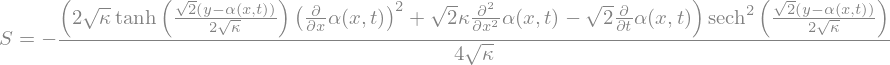

In [6]:
# Print it, for comparison
print("Compare generated expression for S:")
Eq(symbols("S"), S.subs({X: x, Y: y}))

In [7]:
alpha = Rational(1, 4) + A1 * t * sin(B1 * X) + A2 * sin(B2 * X + C2 * t)
alpha_t  = simplify(expand(diff(alpha, t)))
alpha_x  = simplify(expand(diff(alpha, X)))
alpha_xx = simplify(expand(diff(alpha, X, 2)))

print("Expression for α:\n")
print("α =", alpha)

Expression for α:

α = A_1*t*sin(R_x*B_1) + A_2*sin(R_x*B_2 + C_2*t) + 1/4


In [8]:
eta = simplify(η.subs({R[0]: x, R[1]: y, α: alpha.subs({R[0]: x, R[1]: y})}))

print("Expression for η:\n")
print("η =", eta)

Expression for η:

η = tanh(sqrt(2)*(4*A_1*t*sin(B_1*x) + 4*A_2*sin(B_2*x + C_2*t) - 4*y + 1)/(8*sqrt(kappa)))/2 + 1/2


In [9]:
eta0 = simplify(eta.subs({t: 0, α: alpha.subs({R[0]: x, R[1]: y, t: 0})}))

print("Expression for η0:\n")
print("η₀ =", eta0)

Expression for η0:

η₀ = tanh(sqrt(2)*(4*A_2*sin(B_2*x) - 4*y + 1)/(8*sqrt(kappa)))/2 + 1/2


In [10]:
source = S.subs(
    {
        α: alpha,
        diff(α, t):    alpha_t,
        diff(α, X):    alpha_x,
        diff(α, X, 2): alpha_xx
    }
).subs({X: x, Y: y})


print("\nExpression for S:\n")
print("S =", source)


Expression for S:

S = -(2*sqrt(kappa)*(A_1*B_1*t*cos(B_1*x) + A_2*B_2*cos(B_2*x + C_2*t))**2*tanh(sqrt(2)*(-A_1*t*sin(B_1*x) - A_2*sin(B_2*x + C_2*t) + y - 1/4)/(2*sqrt(kappa))) + sqrt(2)*kappa*(-A_1*B_1**2*t*sin(B_1*x) - A_2*B_2**2*sin(B_2*x + C_2*t)) - sqrt(2)*(A_1*sin(B_1*x) + A_2*C_2*cos(B_2*x + C_2*t)))*sech(sqrt(2)*(-A_1*t*sin(B_1*x) - A_2*sin(B_2*x + C_2*t) + y - 1/4)/(2*sqrt(kappa)))**2/(4*sqrt(kappa))


## Code

### Python

Copy the first cell under Source Term directly into your program.
For a performance boost, convert the expressions into lambda functions:

```python
from sympy.utilities.lambdify import lambdify

fast_alpha  = lambdify([x, t],    alpha,  modules='sympy')
fast_eta    = lambdify([x, y, t], eta,    modules='sympy')
fast_eta0   = lambdify([x, y],    eta0,   modules='sympy')
fast_source = lambdify([x, y, t], source, modules='sympy')
```

> Note: Click "Code Toggle" at the top of the page to see the Python expressions.

### C

In [11]:
[(c_name, code), (h_name, header)] = \
codegen([("alpha", alpha),
         ("eta",   eta),
         ("eta0",  eta0),
         ("S",     source)],
         language="C",
         prefix="manufactured",
         project="PFHub")
print("manufactured.h:\n")
print(header)
print("\nmanufactured.c:\n")
print(code)

manufactured.h:

/******************************************************************************
 *                      Code generated with SymPy 1.11.1                      *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                        This file is part of 'PFHub'                        *
 ******************************************************************************/


#ifndef PFHUB__MANUFACTURED__H
#define PFHUB__MANUFACTURED__H

double alpha(double A_1, double A_2, double B_1, double B_2, double C_2, double R_x, double t);
double eta(double A_1, double A_2, double B_1, double B_2, double C_2, double kappa, double t, double x, double y);
double eta0(double A_2, double B_2, double kappa, double x, double y);
double S(double A_1, double A_2, double B_1, double B_2, double C_2, doubl

### Fortran

In [12]:
[(f_name, code), (f_name, header)] = \
codegen([("alpha", alpha),
         ("eta",   eta),
         ("eta0",  eta),
         ("S",     source)],
         language="f95",
         prefix="manufactured",
         project="PFHub")

print("manufactured.f:\n")
print(code)

manufactured.f:

!******************************************************************************
!*                      Code generated with SymPy 1.11.1                      *
!*                                                                            *
!*              See http://www.sympy.org/ for more information.               *
!*                                                                            *
!*                        This file is part of 'PFHub'                        *
!******************************************************************************

REAL*8 function alpha(A_1, A_2, B_1, B_2, C_2, R_x, t)
implicit none
REAL*8, intent(in) :: A_1
REAL*8, intent(in) :: A_2
REAL*8, intent(in) :: B_1
REAL*8, intent(in) :: B_2
REAL*8, intent(in) :: C_2
REAL*8, intent(in) :: R_x
REAL*8, intent(in) :: t

alpha = A_1*t*sin(R_x*B_1) + A_2*sin(R_x*B_2 + C_2*t) + 1.0d0/4.0d0

end function

REAL*8 function eta(A_1, A_2, B_1, B_2, C_2, kappa, t, x, y)
implicit none
REAL*8, intent

### Julia

In [13]:
[(f_name, code)] = \
codegen([("alpha", alpha),
         ("eta",   eta),
         ("eta0",  eta),
         ("S",     source)],
         language="julia",
         prefix="manufactured",
         project="PFHub")

print("manufactured.jl:\n")
print(code)

manufactured.jl:

#   Code generated with SymPy 1.11.1
#
#   See http://www.sympy.org/ for more information.
#
#   This file is part of 'PFHub'

function alpha(A_1, A_2, B_1, B_2, C_2, R_x, t)

    out1 = A_1 .* t .* sin(R_x .* B_1) + A_2 .* sin(R_x .* B_2 + C_2 .* t) + 1 // 4

    return out1
end

function eta(A_1, A_2, B_1, B_2, C_2, kappa, t, x, y)

    out1 = tanh(sqrt(2) * (4 * A_1 .* t .* sin(B_1 .* x) + 4 * A_2 .* sin(B_2 .* x + C_2 .* t) - 4 * y + 1) ./ (8 * sqrt(kappa))) / 2 + 1 // 2

    return out1
end

function eta0(A_1, A_2, B_1, B_2, C_2, kappa, t, x, y)

    out1 = tanh(sqrt(2) * (4 * A_1 .* t .* sin(B_1 .* x) + 4 * A_2 .* sin(B_2 .* x + C_2 .* t) - 4 * y + 1) ./ (8 * sqrt(kappa))) / 2 + 1 // 2

    return out1
end

function S(A_1, A_2, B_1, B_2, C_2, kappa, t, x, y)

    out1 = -(2 * sqrt(kappa) .* (A_1 .* B_1 .* t .* cos(B_1 .* x) + A_2 .* B_2 .* cos(B_2 .* x + C_2 .* t)) .^ 2 .* tanh(sqrt(2) * (-A_1 .* t .* sin(B_1 .* x) - A_2 .* sin(B_2 .* x + C_2 .* t) + y - 1 // 4)

### Mathematica

In [14]:
from sympy.printing import mathematica_code

print("alpha =", mathematica_code(alpha), "\n")
print("eta =", mathematica_code(eta), "\n")
print("eta0 =", mathematica_code(eta0), "\n")
print("S =", mathematica_code(source), "\n")

alpha = A_1*t*Sin[R_x*B_1] + A_2*Sin[R_x*B_2 + C_2*t] + 1/4 

eta = (1/2)*Tanh[(1/8)*2^(1/2)*(4*A_1*t*Sin[B_1*x] + 4*A_2*Sin[B_2*x + C_2*t] - 4*y + 1)/kappa^(1/2)] + 1/2 

eta0 = (1/2)*Tanh[(1/8)*2^(1/2)*(4*A_2*Sin[B_2*x] - 4*y + 1)/kappa^(1/2)] + 1/2 

S = -1/4*(2*kappa^(1/2)*(A_1*B_1*t*Cos[B_1*x] + A_2*B_2*Cos[B_2*x + C_2*t])^2*Tanh[(1/2)*2^(1/2)*(-A_1*t*Sin[B_1*x] - A_2*Sin[B_2*x + C_2*t] + y - 1/4)/kappa^(1/2)] + 2^(1/2)*kappa*(-A_1*B_1^2*t*Sin[B_1*x] - A_2*B_2^2*Sin[B_2*x + C_2*t]) - 2^(1/2)*(A_1*Sin[B_1*x] + A_2*C_2*Cos[B_2*x + C_2*t]))*Sech[(1/2)*2^(1/2)*(-A_1*t*Sin[B_1*x] - A_2*Sin[B_2*x + C_2*t] + y - 1/4)/kappa^(1/2)]^2/kappa^(1/2) 



### Matlab

In [15]:
code = \
codegen([("alpha", alpha),
         ("eta",   eta),
         ("eta0",  eta),
         ("S",     source)],
         language="octave",
         project="PFHub")

print("manufactured.nb:\n")
for f in code[0]:
    print(f)

manufactured.nb:

alpha.m
function out1 = alpha(A_1, A_2, B_1, B_2, C_2, R_x, t)
  %ALPHA  Autogenerated by SymPy
  %   Code generated with SymPy 1.11.1
  %
  %   See http://www.sympy.org/ for more information.
  %
  %   This file is part of 'PFHub'

  out1 = A_1.*t.*sin(R_x.*B_1) + A_2.*sin(R_x.*B_2 + C_2.*t) + 1/4;

end

function out1 = eta(A_1, A_2, B_1, B_2, C_2, kappa, t, x, y)

  out1 = tanh(sqrt(2)*(4*A_1.*t.*sin(B_1.*x) + 4*A_2.*sin(B_2.*x + C_2.*t) - 4*y + 1)./(8*sqrt(kappa)))/2 + 1/2;

end

function out1 = eta0(A_1, A_2, B_1, B_2, C_2, kappa, t, x, y)

  out1 = tanh(sqrt(2)*(4*A_1.*t.*sin(B_1.*x) + 4*A_2.*sin(B_2.*x + C_2.*t) - 4*y + 1)./(8*sqrt(kappa)))/2 + 1/2;

end

function out1 = S(A_1, A_2, B_1, B_2, C_2, kappa, t, x, y)

  out1 = -(2*sqrt(kappa).*(A_1.*B_1.*t.*cos(B_1.*x) + A_2.*B_2.*cos(B_2.*x + C_2.*t)).^2.*tanh(sqrt(2)*(-A_1.*t.*sin(B_1.*x) - A_2.*sin(B_2.*x + C_2.*t) + y - 1/4)./(2*sqrt(kappa))) + sqrt(2)*kappa.*(-A_1.*B_1.^2.*t.*sin(B_1.*x) - A_2.*B_2.^2.*sin(B_2.